# Get forecast data from meteoblue using EODAG

In this tutorial we will show you how to use eodag to get forecast data from [meteoblue](https://content.meteoblue.com/en/business-solutions/weather-apis/dataset-api). The provider configuration and this tutorial have been developed in the context of DOMINO-X.

In [1]:
import datetime
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("meteoblue")

## 1. Search (get data availability and build download request)

There are two use-cases, a search for a product already configured in EODAG, or a search for a dataset not already configured, where you will have a little more to do.

### 1.a. Search from an existing product type:

In [2]:
tomorrow = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
after_tomorrow = (datetime.date.today() + datetime.timedelta(days=2)).isoformat()
aoi_bbox = [-2, 42, 3, 45]

products_from_product_type = dag.search(
    start=tomorrow,
    end=after_tomorrow,
    geom=aoi_bbox,
    productType="NEMSGLOBAL_TCDC",
)
print(
    "%s product built %s,\n using queries=%s\n"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties["queries"],
    )
)

None product built EOProduct(id=NEMSGLOBAL_TCDC_20250115_20250116_fd21a295b1c5795ca4449f051c20faf1884d39cb, provider=meteoblue),
 using queries=[{'domain': 'NEMSGLOBAL', 'gapFillDomain': None, 'timeResolution': 'daily', 'codes': [{'code': 71, 'level': 'sfc', 'aggregation': 'mean'}]}]



In [3]:
products_from_product_type[0].properties["storageStatus"], products_from_product_type[0].properties["datapoints"]

('ONLINE', 2328)

We can see that the product is `OFFLINE`, which means that it is not directly avalaible for download and will need to be ordered first.

We also displayed the `datapoints` property (credits), needed for this download (search does not consume datapoints).

### 1.b. Search using a custom request:

Here we use a set of custom parameters corresponding to `NEMSGLOBAL_TCDC`, which should result to the same request sent to `meteoblue`.

You can compose your own request using meteoblue documentation: [dataset API](https://docs.meteoblue.com/en/weather-apis/dataset-api/dataset-api), [available datasets/models](https://docs.meteoblue.com/en/meteo/data-sources/datasets), [available variables](https://docs-staging.meteoblue.com/en/meteo/variables/weather-variables), or also meteoblue [dataset API configurator](https://www.meteoblue.com/en/weather-api/dataset-api/index).

In [4]:
meteoblue_req_params = {
    "queries":[
        {
            "domain":"NEMSGLOBAL","gapFillDomain":None,"timeResolution":"daily",
            "codes":[{"code":71,"level":"sfc","aggregation":"mean"}],
        }
    ],
    "format": "netCDF",
    "units":{"temperature":"C","velocity":"km/h","length":"metric","energy":"watts"},
    "timeIntervalsAlignment": None,
}

products_from_custom_req = dag.search(
    start=tomorrow,
    end=after_tomorrow,
    geom=aoi_bbox,
    **meteoblue_req_params,
)
# downloadLink property must be the same with the two request methods,
# as they are built from the same custom request arguments
if (
    products_from_custom_req[0].properties["downloadLink"]
    == products_from_product_type[0].properties["downloadLink"]
):
    print(
        "Request using productType or directly meteoblue query result to the\n",
        "same downloadLink %s"
        % (
            products_from_custom_req[0].properties["downloadLink"],
        )
    )

Request using productType or directly meteoblue query result to the
 same downloadLink https://my.meteoblue.com/dataset/query?{"format": "netCDF", "geometry": {"coordinates": [[[-2.0, 42.0], [-2.0, 45.0], [3.0, 45.0], [3.0, 42.0], [-2.0, 42.0]]], "type": "Polygon"}, "queries": [{"codes": [{"aggregation": "mean", "code": 71, "level": "sfc"}], "domain": "NEMSGLOBAL", "gapFillDomain": null, "timeResolution": "daily"}], "timeIntervals": ["2025-01-15/2025-01-15"], "units": {"energy": "watts", "length": "metric", "temperature": "C", "velocity": "km/h"}}


## 2. Open dataset with `to_xarray` from [eodag-cube](https://github.com/CS-SI/eodag-cube) and plot over a map using `cartopy`

In [5]:
# Get XarrayDict
xd = products_from_product_type[0].to_xarray()
xd

0.00B [00:00, ?B/s]

XarrayDict (1)


In [6]:
# Dataset from XarrayDict first value
ds = next(iter(xd.values()))
ds

<xarray.Dataset> Size: 2kB
Dimensions:            (x: 99, y: 1, time: 1)
Coordinates:
  * time               (time) float64 8B 1.737e+09
Dimensions without coordinates: x, y
Data variables:
    lat                (x, y) float32 396B ...
    lon                (x, y) float32 396B ...
    asl                (x, y) float32 396B ...
    Cloud Cover Total  (x, y, time) float32 396B ...
Attributes: (12/24)
    domain:                           NEMSGLOBAL
    keywords:                         meteoblue,NEMS,NEMSGLOBAL,CLOUD,COVER,T...
    license:                          proprietary
    title:                            NEMSGLOBAL_TCDC_20250115_20250116_fd21a...
    missionStartDate:                 1984-01-01T00:00:00Z
    _id:                              NEMSGLOBAL_TCDC
    ...                               ...
    format:                           netCDF
    timeIntervalsAlignment:           None
    orderLink:                        https://my.meteoblue.com/dataset/query?...
    timeIntervals:                    ['2025-01-15/2025-01-15']
    qs:                               {'format': 'netCDF', 'geometry': {'coor...
    _dc_qs:                           %7B%22format%22%3A+%22netCDF%22%2C+%22g...

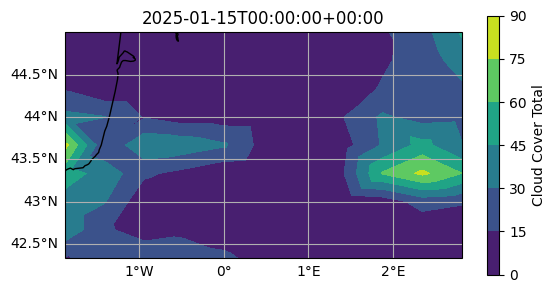

In [7]:
from datetime import datetime, UTC
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# data and coordinates from dataset
cct = ds["Cloud Cover Total"][:, 0, 0]
lats = ds.lat[:, 0]
lons = ds.lon[:, 0]
title = datetime.fromtimestamp(int(ds.time), UTC).isoformat()

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# filled contour plot
tcf = ax.tricontourf(lons, lats, cct)
ax.set_title(title)
ax.coastlines()

# colorbar
cbar = plt.colorbar(tcf, ax=ax, shrink=0.7, label=cct.name)

# gridlines
gridlines = ax.gridlines(draw_labels=True)
gridlines.right_labels = False
gridlines.top_labels = False

plt.show()